In [8]:
from tqdm import tqdm
from skimage.io import imread
from skimage import color
from scipy.misc import imresize
from scipy import fftpack
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn import svm

%matplotlib inline
np.seterr(divide='raise')

{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [9]:
from utils import get_labels_dict
from constants import LABELS, WEATHER_IDX
WEATHER_LABELS = [LABELS[i] for i in WEATHER_IDX]
HSV = ["H", "S", "V"]
W, H, D = 256, 256, 3
W2, H2 = W//2, H//2

print(LABELS)

['clear', 'cloudy', 'haze', 'partly_cloudy', 'agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'conventional_mine', 'cultivation', 'habitation', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [10]:
labels = get_labels_dict()

In [11]:
def get_images_of_tag(tag, n):
    """
    Return n image with that match the tag
    """
    idx = LABELS.index(tag)
    for k in labels:
        if labels[k][idx] == 1:
            yield k
            n -= 1
            if n ==0:
                break

In [12]:
[f for f in get_images_of_tag("artisinal_mine", 5)]

['train_19501', 'train_34194', 'train_3991', 'train_9830', 'train_38265']

In [13]:
def get_channels(img):
    """
    Return a grey scale image for each channel
    """
    res = []
    for c in range(D):
        i = np.zeros((W, H, D))
        for k in range(D):
            i[:,:,k] = img[:,:,c]
        res.append(i)
    return np.array(res)

def show(img):
    s = img.shape
    if len(s) == 2:
        # grey scale
        img = img.reshape((s[0], s[1], 1))
        img = get_channels(img)[0]
    plt.imshow(np.asarray(img[:,:,0:D], dtype=np.uint8))
    plt.show()
    
def open_img(name):
    #return imread(name)
    #return 255 - np.asarray(Image.open(name, "r"), dtype=np.float32)[:,:,0:3]
    return 255 - np.asarray(Image.open(name, "r"), dtype=np.uint8)[:,:,0:D]

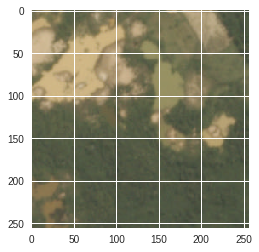

pixel 0,0 [117 108  83]


In [14]:
img = open_img("rawInput/train-jpg/train_15510.jpg")
show(img)

print("pixel 0,0", img[0,0,:])

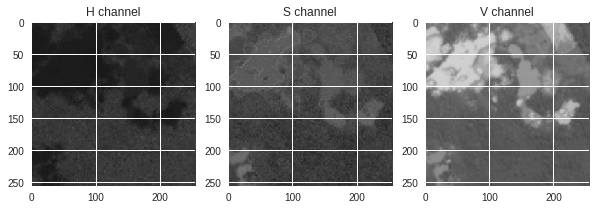

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
img = np.asarray(img, dtype=np.uint8)
hsv = [np.asarray(c, dtype=np.uint8) for c in get_channels(color.rgb2hsv(img) * 255)]
for i, c in enumerate(HSV):
    ax[i].imshow(hsv[i], cmap = 'gray')
    ax[i].set_title('{c} channel'.format(c=c))


# Image features analysis

In [16]:
img_names = np.array([k for k in labels])
sampled_imgs = []
process_count = cpu_count()

for tag in WEATHER_LABELS:
    for i in get_images_of_tag(tag, 20):
        sampled_imgs.append(i)

sampled_labels = { k: labels[k] for k in sampled_imgs }
print(len(sampled_labels))

80


## 1) HSV channels

In [17]:
hsv_dist = {}

def get_hsv_channels(img_name):
    img = open_img("rawInput/train-jpg/{k}.jpg".format(k=img_name))
    img = color.rgb2hsv(img) * 255
    hsv = [img[:,:,i] for i, _ in enumerate(HSV)]
    tags = [LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1]
    return tags, hsv

with ThreadPoolExecutor(process_count) as pool:
    for tags, hsv in tqdm(
            pool.map(
                get_hsv_channels,
                [img_name for img_name in sampled_labels]
            ),
            total=len(sampled_labels)
        ):
            for tag in tags:
                if tag in WEATHER_LABELS:
                    if tag not in hsv_dist:
                        hsv_dist[tag] = { c: [] for c in HSV }
                        hsv_dist[tag]["n"] = 0
                    hsv_dist[tag]["n"] += 1
                    for i, c in enumerate(HSV):
                        hsv_dist[tag][c].append(hsv[i])

for tag in WEATHER_LABELS:
    for c in HSV:
        hsv_dist[tag][c] = np.array(hsv_dist[tag][c]).flatten()


100%|██████████| 80/80 [00:00<00:00, 107.20it/s]


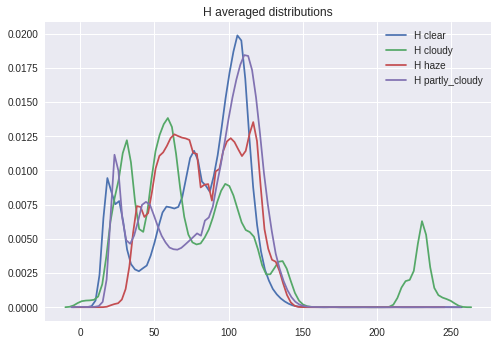

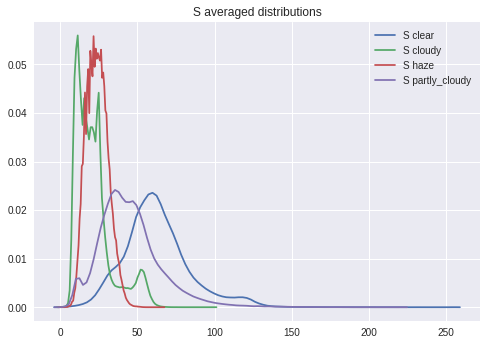

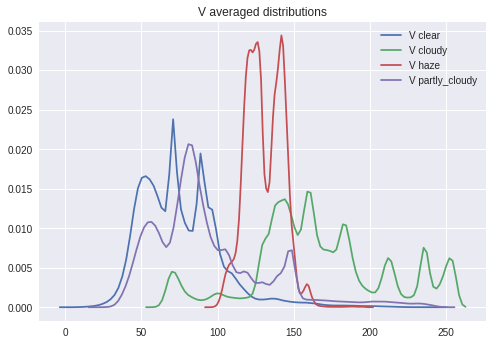

In [18]:
sns.set(color_codes=True)
for c in HSV:
    for i in WEATHER_IDX:
        sns.kdeplot(hsv_dist[LABELS[i]][c], label="{c} {tag}".format(c=c, tag=LABELS[i]))
    plt.legend()
    plt.title("{c} averaged distributions".format(c=c))
    plt.show()

## 2) Fourrier transform

In [19]:
img = open_img("rawInput/train-jpg/train_15510.jpg")
img = np.asarray(img[:,:,0:D], dtype=np.float32)
F1 = fftpack.fft2(img)
# Now shift so that low spatial frequencies are in the center.
F2 = fftpack.fftshift(F1)
# the 2D power spectrum is:
psd2D = np.abs(F2)**2

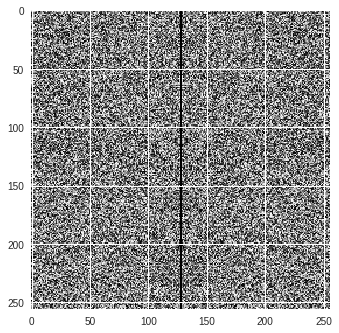

In [20]:
show(np.asarray(get_channels(psd2D)[1], dtype=np.uint8))

In [21]:
def low_pass(img, t):
    mask = np.zeros((W, H, D), np.uint8)
    mask[W2-t:W2+t, H2-t:H2+t, :] = 1
    return img * mask
    
def high_pass(img, t):
    mask = np.zeros((W, H, D), np.uint8)
    mask[:W2-t:, :, :] = 1
    mask[W2+t:, :, :] = 1
    mask[:, :H2-t, :] = 1
    mask[:, H2+t:, :] = 1
    return img * mask
    
def get_magnitude_repartition(magnitude_spectrum):
    magnitude_repartition = [np.zeros(int(W2 * (2 ** 0.5)) + 1) for k in range(3)]
    for i in range(W):
        i2 = (i - W2) ** 2
        for j in range(H):
            r = int((i2 + (j - H2) ** 2) ** 0.5)
            for k in range(D):
                magnitude_repartition[k][r] += magnitude_spectrum[i, j, k] / (r + 1)
    return magnitude_repartition

def get_hsv_freq_dist(img_name):
    img = open_img("rawInput/train-jpg/{name}.jpg".format(name=img_name))
    img = np.asarray(img[:,:,0:D], dtype=np.float32)
    hsv = color.rgb2hsv(img / 255) * 255
    f = fftpack.fft2(hsv, axes=(0, 1))
    f = fftpack.fftshift(f)
    abs_f = np.abs(f) 

    tags = [LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1]
    img = np.asarray(img, dtype=np.uint8)
    hsv = np.asarray(hsv, dtype=np.uint8)
    return img, hsv, tags, f, 20 * (np.log(abs_f + 0.00001) + 2)

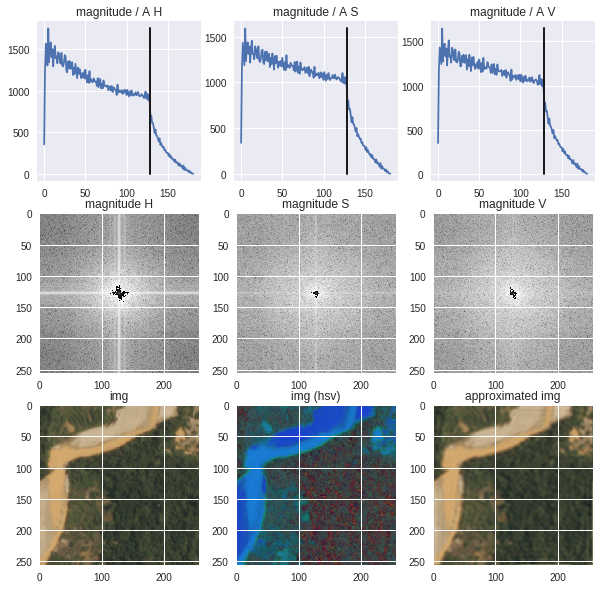

In [22]:


# ['train_3537', 'train_18469', 'train_13594', 'train_36017', 'train_6174']
img, hsv, _, f, log_abs_f = get_hsv_freq_dist("train_3537")
    
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))


repartition = get_magnitude_repartition(log_abs_f)
for i, c in enumerate(HSV):
    ax[0,i].plot(repartition[i])
    ax[0,i].plot([W2, W2], [0, np.max(repartition[i])], 'k-', lw=2)
    ax[0,i].set_title('magnitude / A {c}'.format(c=c))

for i, c in enumerate(HSV):
    freq = get_channels(log_abs_f)[i]
    freq = np.asarray(freq, dtype=np.uint8)
    # ax[0,1].imshow(get_channels(log_abs_f)[0], interpolation="none")
    ax[1,i].imshow(freq, interpolation="none")
    ax[1,i].set_title('magnitude {c}'.format(c=c))

ax[2,0].imshow(img, interpolation="none")
ax[2,0].set_title('img')

ax[2,1].imshow(hsv, interpolation="none")
ax[2,1].set_title('img (hsv)')

i = f
i = low_pass(i, 30)
i = fftpack.ifftshift(i)
i = np.real(fftpack.ifft2(i, axes=(0, 1)))
i = color.hsv2rgb(i / 255) * 255
i = np.asarray(i, dtype=np.uint8)


ax[2,2].imshow(i, interpolation="none")
ax[2,2].set_title('approximated img')
plt.show()

In [23]:
hsv_freq_dist = {}

with ThreadPoolExecutor(process_count) as pool:
    for _, _, tags, _, log_magnitude in tqdm(
            pool.map(
                get_hsv_freq_dist,
                [img_name for img_name in sampled_labels]
            ),
            total=len(sampled_labels)
        ):
            repartition = get_magnitude_repartition(log_magnitude)
            for tag in tags:
                if tag in WEATHER_LABELS:
                    if tag not in hsv_freq_dist:
                        hsv_freq_dist[tag] = { c: [] for c in HSV }
                        hsv_freq_dist[tag]["n"] = 0
                    hsv_freq_dist[tag]["n"] += 1
                    for i, c in enumerate(HSV):
                        hsv_freq_dist[tag][c].append(repartition[i])


for tag in WEATHER_LABELS:
    for c in HSV:
        hsv_freq_dist[tag][c] = np.mean(np.array(hsv_freq_dist[tag][c]), axis=0)

100%|██████████| 80/80 [00:16<00:00,  4.82it/s]


In [24]:
len(hsv_freq_dist['clear']['H'])

182

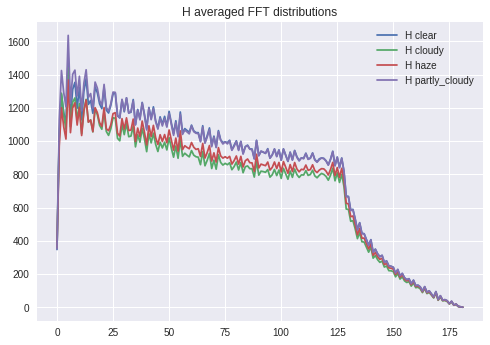

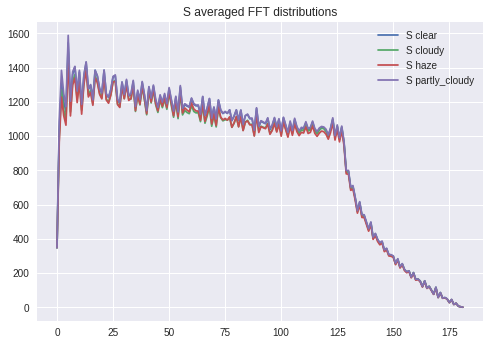

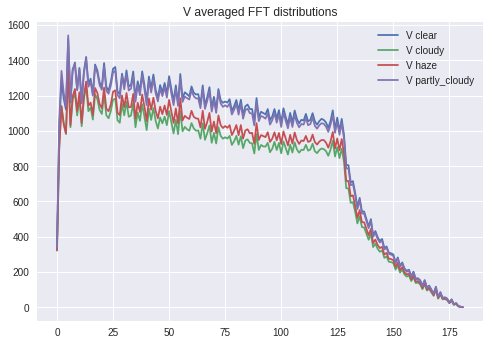

In [25]:
sns.set(color_codes=True)
for c in HSV:
    for i in WEATHER_IDX:
        plt.plot(hsv_freq_dist[LABELS[i]][c], label="{c} {tag}".format(c=c, tag=LABELS[i]))
    plt.legend()
    plt.title("{c} averaged FFT distributions".format(c=c))
    plt.show()

# Classification

In [ ]:
list_imgs = [f.split(".")[0] for f in sorted(os.listdir("rawInput/train-jpg"))]
X, Y = [], []

def get_quantile(data, n=10):
    return np.percentile(data, np.arange(0, 100, n))

with tqdm(total=len(list_imgs)) as pbar:
    for img_name in list_imgs:
        img = open_img("rawInput/train-jpg/{k}.jpg".format(k=img_name))
        hsv = color.rgb2hsv(img) * 255
        tag = [LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1 and i in WEATHER_IDX][0]
        X.append(np.concatenate([get_quantile(hsv[:,:,i]) for i in range(D)]))
        Y.append(tag)
        pbar.update(1)

In [ ]:
X = np.array(X)
m = np.mean(X, axis=0)
X -= m
Y = np.array(Y)

In [ ]:
X.shape, Y.shape, m.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
clf = svm.SVC(kernel='linear', C=0.1).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
predictions = clf.predict(X_test)
scores = { c: {"tp": 0, "fp": 0, "fn": 0 } for c in WEATHER_LABELS }
for i, p in enumerate(predictions):
    truth = y_test[i]
    if truth == p:
        scores[truth]["tp"] += 1
    else:
        scores[truth]["fn"] += 1
        scores[p]["fp"] += 1

scores

In [ ]:
sum(predictions == y_test), len(predictions)